*Alexis Adrian Carrillo Medina (316733780)*

---
<center> <h1>  <b> Simulacion Estocastica </b> <br>
<b> Tarea 4 </b>
<hr>

### **Bibliotecas**

In [52]:
using Random, Distributions, KernelDensity, Plots, QuadGK, SpecialFunctions, StatsPlots

### **1) Programe el algoritmo de Metrópolis-Hastings (MH) en el lenguaje de programación de su preferencia. Elija tres distribuciones de probabilidad y estime mediante MCMC los parámetros de la distribución correspondiente haciendo uso de cadenas MH con 100, 1000 y 10000 iteraciones.**

Programemos un Metropolis-Hastings General

In [53]:
function MetropolisHastings(f,params1,Q,q,params2,n)
    
    """ 
    Algoritmo de Metropolis-Hastings para f,Q,q generales
    
    f := Distribucion a simular
    params1 := Parametros de f
    Q := Distribucion auxiliar
    q := Funcion de transicion de Q
    params2 := Parametros de Q
    n := Numero de movimientos en la cadena
    
    """
    
    # Vector de estados de X
    statesX=[]
    
    # Distribucion Inicial de X
    X=Q(params2,0)
    
    # MetropolisHastings
    for i in 1:n
        
        # Guardamos los estados
        append!(statesX,X)
        
        # U ~ U(0,1)
        U=rand(Uniform())
        
        # X ~ L(Q)
        Xnew=Q(params2,X)
        
        # Aceptacion
        if U<= min(1,f(Xnew,params1)/f(X,params1)*q(Xnew,X,params2)/q(X,Xnew,params2))
            X=Xnew
        end
    end
    
    # Regresamos la cadena despues del quemado
    return statesX[ceil(Int,0.02*n):n*length(X)-1]
    
end

MetropolisHastings (generic function with 1 method)

#### **a) Distribucion 1**

Definamos

$$f(x,y; \sigma^2)= \frac{x}{\sigma^2} e^{-\frac{x^2}{2 \sigma^2}} \cdot  \frac{y}{\sigma^2} e^{-\frac{y^2}{2 \sigma^2}} \quad, (x,y) \in [0,\infty)\times [0,\infty) $$

Simularemos $X \sim \mathcal{L}(f)$ con $\sigma^2=2$ , la cual es una distribucion multivariada, con marginales dadas por

$$f_X(x; \sigma^2)=\frac{x}{\sigma^2} e^{-\frac{x^2}{2 \sigma^2}} $$

Para ello utilizaremos un Metropolis-Hastings simetrico con $Q \sim \mathcal{L}(Q)=U(0,\delta) \times U(0,\delta)$

**Funcionones auxiliares**

In [54]:
# Distribucion a simular -----
function f(X,σ=2)
    # Soporte de la funcion
    if (X[1] >= 0) & (X[2] >=0)
        return (X[1]/σ)*(ℯ^(-(X[1]^2/(2*σ))))*(X[2]/σ)*(ℯ^(-(X[2]^2/(2*σ))))
    else
        return 0
    end
end

# Distribucion Marginal a simular -----
function fMarginal(x,σ=2)
    # Soporte de la funcion
    if (x >= 0) 
        return (x/σ)*(ℯ^(-(x^2/(2*σ))))
    else
        return 0
    end
end

# Distribucion auxiliar -----
function Q(params,X)
    return (rand(Uniform(params[1],params[2]),1)[1],rand(Uniform(params[1],params[2]),1)[1])
end

# Funcion de transicion -----
function q(X,Y,params)
    return 1
end

q (generic function with 1 method)

Observemos a la densidad multivariada

┌ Info: Saved animation to 
│   fn = /home/a-carrillo/Documents/Escuela/Tareas/Simulacion Estocastica/Tarea 4/tmp.gif
└ @ Plots /home/a-carrillo/.julia/packages/Plots/D7Ica/src/animation.jl:104


Plots.AnimatedGif("/home/a-carrillo/Documents/Escuela/Tareas/Simulacion Estocastica/Tarea 4/tmp.gif")
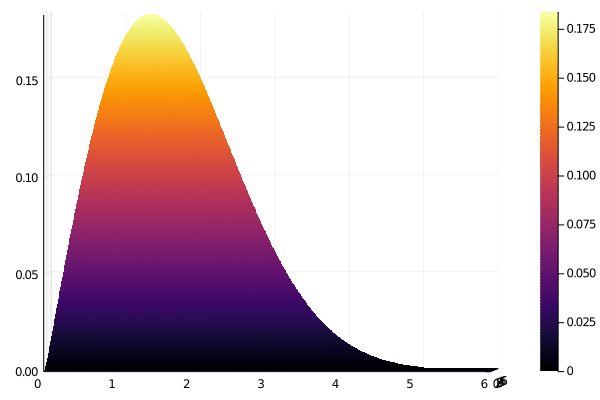

In [55]:
x=range(0,stop=6,length=1000)
y=range(0,stop=6,length=1000)

g(x,y)=(x/2)*(ℯ^(-(x^2/(2*2))))*(y/2)*(ℯ^(-(y^2/(2*2))))

@gif for i in 1:100
    plot(x,y,g,st=:surface,camera=(i,i))
end

**Prueba**

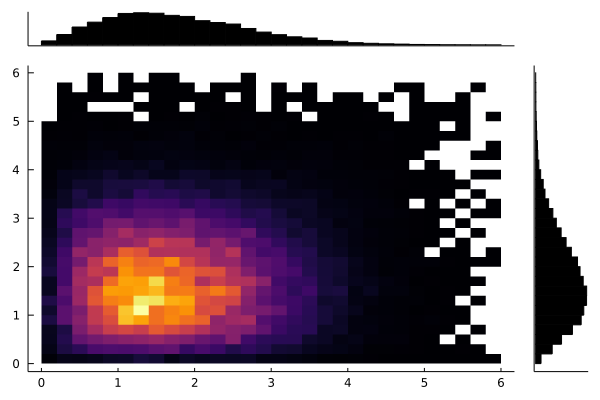

In [56]:
X=MetropolisHastings(f,2,Q,q,[0,6],100000)

statesX=[]
statesY=[]
for i in range(1,length(X),step=2)
    append!(statesX,X[i])
    append!(statesY,X[i+1])
end

marginalhist(statesX,statesY)

A primera vista: parece ser que nuestra simulacion coincide con la distribucion. <br>
Veamos mas de cerca a las marginales

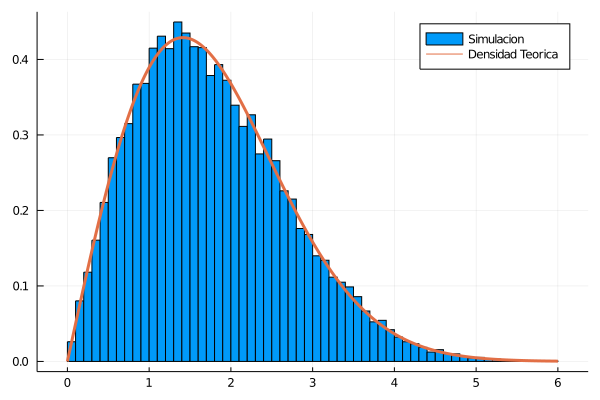

In [57]:
histogram(statesX,normed=true,label="Simulacion")
plot!(range(0,6,length=10000),fMarginal,label="Densidad Teorica",lw=3)

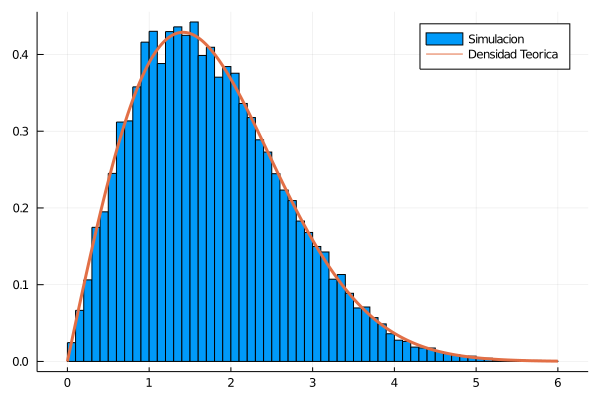

In [58]:
histogram(statesY,normed=true,label="Simulacion")
plot!(range(0,6,length=10000),fMarginal,label="Densidad Teorica",lw=3)

En efecto, estamos simulando de la distribucion multivariada

**Estimacion de parametros**

Usando metodos Montecarlo, podemos estimar el parametro $\sigma$ como 

$$\sigma^2 \approx \frac{2}{\pi( T-T_B)^2} \left(\sum_{i=T_B+1}^T X_i+Y_i\right)^2 $$

Donde $T_B$= Tiempo de quemado, $T$= Tiempo total

In [59]:
# Numero de Simulaciones
n=[100,1000,10000]

# n=100
X1=MetropolisHastings(f,2,Q,q,[0,6],n[1])
X1=Vector{Float64}(vec(X1))

# n=10000
X2=MetropolisHastings(f,2,Q,q,[0,6],n[2])
X2=Vector{Float64}(vec(X2))

# n=10000
X3=MetropolisHastings(f,2,Q,q,[0,6],n[3])
X3=Vector{Float64}(vec(X3))

# Estimacion
σ1=2/(length(X1)^2*π)*(sum(X1))^2
σ2=2/(length(X2)^2*π)*(sum(X2))^2
σ3=2/(length(X3)^2*π)*(sum(X3))^2

print("La estimacion de σ, con 100, es :")
print(σ1)
print("\n")

print("La estimacion de σ, con 1000, es :")
print(σ2)
print("\n")

print("La estimacion de σ, con 10000, es :")
print(σ3)

La estimacion de σ, con 100, es :2.0503091276438545
La estimacion de σ, con 1000, es :2.1911460891789725
La estimacion de σ, con 10000, es :2.053205722926845

#### **b) Distribucion 2**

Simularemos $X \sim Beta(\alpha=1/2,\beta=1/2)$. Recordemos que

$$\mathbb{E}(X)=\frac{\alpha}{\alpha+\beta} $$

$$\mathbb{E}(X^2)=Var(X)+\mathbb{E}(X)^2=\frac{(\alpha+1)\alpha}{(\alpha+\beta+1)(\alpha+\beta)} $$

$$\Rightarrow \hat \beta = \frac{\hat \alpha (1-\mathbb{E}(X))}{\mathbb{E}(X)}, \quad \hat \alpha=\frac{\mathbb{E}(X)^2(1-\mathbb{E}(X))-Var(X)\mathbb{E}(X)}{Var(X)}  $$

Usaremos un Metropolis-Hastings con caminata aleatoria, entonces $Q \sim N(X,1)$ lo que implica $q(x,y) \propto e^{-\frac{(y-x)^2}{2}}$

**Funciones auxiliares**

In [60]:
# Distribucion a simular ----
function f(X,params=[1/2,1/2])
    # Soporte de la funcion
    if (X >= 0) & (X <= 1) 
        return ((gamma(params[1]+params[2]))/(gamma(params[1])*gamma(params[2])))*X^(params[1]-1)*(1-X)^(params[2]-1)
    else
        return 0
    end
end

# Distribucion auxiliar ----
function Q(params,X)
    if X==0
        return rand(Normal(params[1],params[2]))
    else
        return rand(Normal(params[1]+X[1],params[2]))
    end
end

# Funcion de transicion ----
function q(X,Y,params)
    return ℯ^(-(Y-X)^2/2)
end

q (generic function with 1 method)

**Prueba**

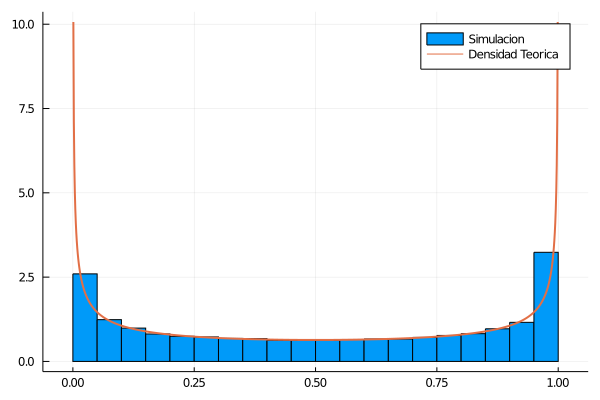

In [61]:
X=MetropolisHastings(f,[1/2,1/2],Q,q,[0,1],100000)
X=Vector{Float64}(vec(X))
histogram(X, normed=true,label="Simulacion")
plot!(range(0,1,length=1000),f,label="Densidad Teorica",lw=2)

**Estimacion de parametros**

Usando metodos Montecarlo, podemos estimar los parametros $\alpha, \beta$ como 

$$\bar X \approx \mathbb{E}(X) \approx \frac{1}{T_B-T} \sum_{i=TB+1}^T X_i$$
$$S^2 \approx Var(X) \approx \frac{1}{T_B-T-1} \sum_{i=TB+1}^T (X_i-\bar X)^2 $$

$$\Rightarrow \hat \beta = \frac{\hat \alpha (1-\bar X)}{\bar X}, \quad \hat \alpha=\frac{\bar X^2(1-\bar X)-S^2\bar X}{S^2} $$

Donde $T_B$= Tiempo de quemado, $T$= Tiempo total

In [62]:
# Numero de Simulaciones
n=[100,1000,1000000]

# n=100
X1=MetropolisHastings(f,[1/2,1/2],Q,q,[0,1],n[1])
X1=Vector{Float64}(vec(X1))

# n=10000
X2=MetropolisHastings(f,[1/2,1/2],Q,q,[0,1],n[2])
X2=Vector{Float64}(vec(X2))

# n=10000
X3=MetropolisHastings(f,[1/2,1/2],Q,q,[0,1],n[3])
X3=Vector{Float64}(vec(X3))


# Esperanza
E1=mean(X1)
E2=mean(X3)
E3=mean(X3)

# Varianza
V1=var(X1)
V2=var(X2)
V3=var(X3)

# Estimacion α
α1=(E1^2*(1-E1)-V1*E1)/(V1)
α2=(E2^2*(1-E2)-V2*E2)/(V2)
α3=(E3^2*(1-E3)-V3*E3)/(V3)

# Estimacion β
β1=(α1*(1-E1))/E1
β2=(α2*(1-E2))/E2
β3=(α3*(1-E3))/E3

print("La estimacion de α, con 100, es :")
print(α1)
print("\n")
print("La estimacion de β, con 100, es :")
print(β1)
print("\n")

print("\n")
print("La estimacion de α, con 1000, es :")
print(α2)
print("\n")
print("La estimacion de β, con 1000, es :")
print(β2)
print("\n")

print("\n")
print("La estimacion de α, con 10000, es :")
print(α3)
print("\n")
print("La estimacion de β, con 10000, es :")
print(β3)

La estimacion de α, con 100, es :-0.15413661493162406
La estimacion de β, con 100, es :-0.15402750797873338

La estimacion de α, con 1000, es :0.497665965082458
La estimacion de β, con 1000, es :0.49665150886367665

La estimacion de α, con 10000, es :0.5002724181984253
La estimacion de β, con 10000, es :0.49925264891273163

#### **c) Distribucion 3**

Definamos

$$f(x,y; \mu_1, \mu_2)= \sqrt{\frac{1}{\pi x^3}} e^{-\frac{2(x-\mu_1)^2}{2 \mu_1^2 x}} \cdot \sqrt{\frac{1}{\pi y^3}} e^{-\frac{2(y-\mu_2)^2}{2 \mu_2^2 y}} $$

Simularemos $X \sim \mathcal{L}(f)$, la cual es una distribucion multivariada con marginales

$$ f_X(x;\mu_1)= \sqrt{\frac{1}{\pi x^3}} e^{-\frac{2(x-\mu_1)^2}{2 \mu_1^2 x}}$$

$$f_Y(y;\mu_1)= \sqrt{\frac{1}{\pi y^3}} e^{-\frac{2(y-\mu_2)^2}{2 \mu_2^2 y}} $$

Las cuales cumplen que

$$ \mathbb{E}_{f_X}(X)=\mu_1$$
$$ \mathbb{E}_{f_Y}(Y)=\mu_2$$

Para esto usaremos un Metropolis-Hastings con Caminata Aleatoria, entonces $Q \sim U(X-1,X+1)$ lo que implica $q(x,y) \propto \frac{1}{2}$

**Funciones auxiliares**

In [63]:
# Distribucion a simular ----
function f(X,params=[1,3])
    # Soporte de la funcion
    if (X[1] > 0) & (X[2] > 0) 
        return sqrt(1/(π*X[1]^3))*(ℯ^(-((2*(X[1]-params[1])^2)/(2*params[1]^2*X[1]))))*sqrt(1/(π*X[2]^3))*(ℯ^(-((2*(X[2]-params[2])^2)/(2*params[2]^2*X[2]))))
    else
        return 0
    end
end

# Distribucion Marginal de X a simular ----
function fX(X,params=1)
    # Soporte de la funcion
    if (X > 0)
        return (sqrt(1/(π*X^3))*ℯ^(-((2*(X-params)^2)/(2*params^2*X))))
    else
        return 0
    end
end

# Distribucion Marginal de Y a simular ----
function fY(Y,params=3)
    # Soporte de la funcion
    if (Y > 0)
        return (sqrt(1/(π*Y^3))*ℯ^(-((2*(Y-params)^2)/(2*params^2*Y))))
    else
        return 0
    end
end

# Distribucion auxiliar ----
function Q(params,X)
    if X==0
        return (rand(Uniform(-params[1],params[2])),rand(Uniform(-params[1],params[2])))
    else
        return (rand(Uniform(X[1]-params[1],X[1]+params[2])),rand(Uniform(X[2]-params[1],X[2]+params[2])))
    end
end

# Funcion de transicion ----
function q(X,Y,params)
    return 1/2
end

q (generic function with 1 method)

Veamos a la distribucion

┌ Info: Saved animation to 
│   fn = /home/a-carrillo/Documents/Escuela/Tareas/Simulacion Estocastica/Tarea 4/tmp.gif
└ @ Plots /home/a-carrillo/.julia/packages/Plots/D7Ica/src/animation.jl:104


Plots.AnimatedGif("/home/a-carrillo/Documents/Escuela/Tareas/Simulacion Estocastica/Tarea 4/tmp.gif")
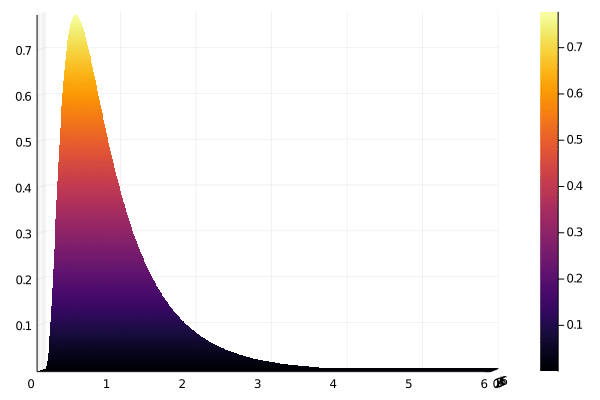

In [64]:
x=range(0,stop=6,length=1000)
y=range(0,stop=6,length=1000)

g(x,y)=(sqrt(1/(π*x^3))*ℯ^(-((2*(x-1)^2)/(2*1^2*x))))*(sqrt(1/(π*y^3))*(sqrt(1/(π*y^3)))*ℯ^(-((2*(y-3)^2)/(2*3^2*y))))

@gif for i in 1:100
    plot(x,y,g,st=:surface,camera=(i,i))
end

**Prueba**

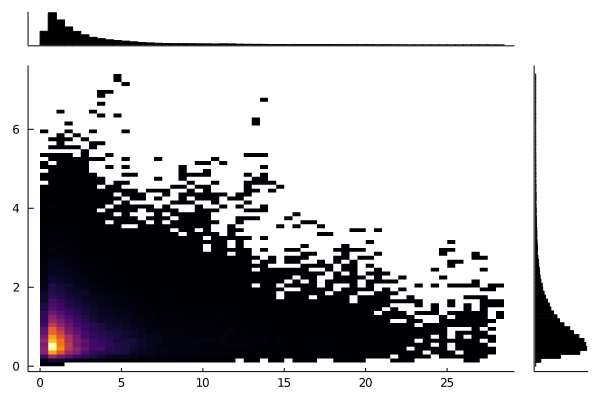

In [65]:
X=MetropolisHastings(f,[1,3],Q,q,[1,1],100000)

statesX=[]
statesY=[]
for i in range(1,length(X),step=2)
    append!(statesX,X[i])
    append!(statesY,X[i+1])
end

marginalhist(statesX,statesY)

Parece ser que la distribucion coincide <br>
Veamos mas de cerca las marginales

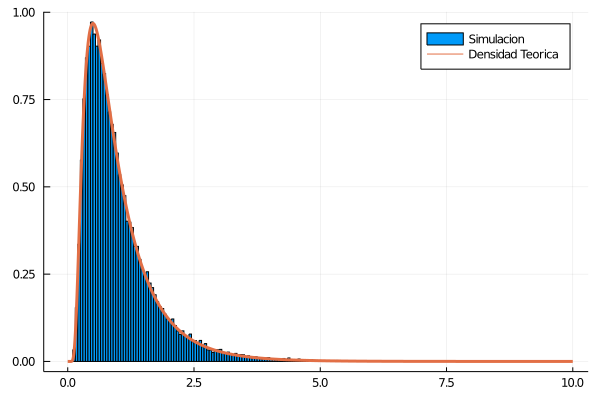

In [66]:
histogram(statesY,normed=true,label="Simulacion")
plot!(range(0,10,length=10000),fX,label="Densidad Teorica",lw=3)

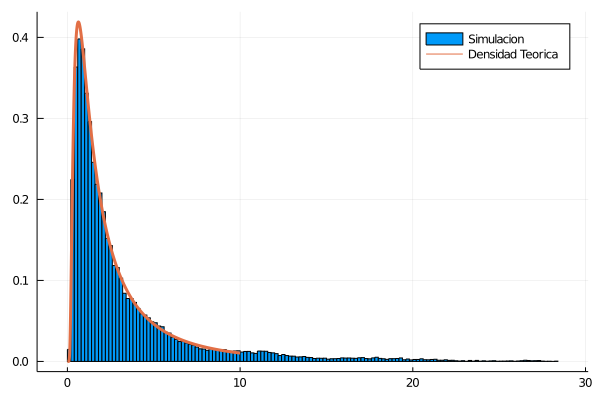

In [67]:
histogram(statesX,normed=true,label="Simulacion")
plot!(range(0,10,length=10000),fY,label="Densidad Teorica",lw=3)

**Estimacion de parametros**

Usando metodos Montecarlo podemos estimar $\mu_1, \mu_2$ como

$$\mu_1 \approx \frac{2}{T - T_B}\sum_{i=0}^n X_i $$

$$\mu_2 \approx \frac{2}{T - T_B}\sum_{i=0}^n Y_i $$

In [68]:
# Numero de Simulaciones
n=[100,1000,1000000]

# n=100
X1=MetropolisHastings(f,[1,3],Q,q,[1,1],n[1])
statesX1=[]
statesY1=[]
for i in range(1,length(X1),step=2)
    append!(statesX1,X1[i])
    append!(statesY1,X1[i+1])
end

# n=10000
X2=MetropolisHastings(f,[1,3],Q,q,[1,1],n[2])
statesX2=[]
statesY2=[]
for i in range(1,length(X2),step=2)
    append!(statesX2,X2[i])
    append!(statesY2,X2[i+1])
end

# n=10000
X3=MetropolisHastings(f,[1,3],Q,q,[1,1],n[3])
statesX3=[]
statesY3=[]
for i in range(1,length(X3),step=2)
    append!(statesX3,X3[i])
    append!(statesY3,X3[i+1])
end


# Esperanza
μ_11=mean(statesX1)
μ_21=mean(statesY1)

μ_12=mean(statesX2)
μ_22=mean(statesY2)

μ_13=mean(statesX3)
μ_23=mean(statesY3)

print("La estimacion de μ_2, con 100, es :")
print(μ_11)
print("\n")
print("La estimacion de μ_1, con 100, es :")
print(μ_21)
print("\n")

print("\n")
print("La estimacion de μ_2, con 100, es :")
print(μ_12)
print("\n")
print("La estimacion de μ_1, con 100, es :")
print(μ_22)
print("\n")

print("\n")
print("La estimacion de μ_2, con 100, es :")
print(μ_13)
print("\n")
print("La estimacion de μ_1, con 100, es :")
print(μ_23)
print("\n")

La estimacion de μ_2, con 100, es :2.7682924257991908
La estimacion de μ_1, con 100, es :1.2286478859502183

La estimacion de μ_2, con 100, es :3.2810957753793235
La estimacion de μ_1, con 100, es :0.9067640228576621

La estimacion de μ_2, con 100, es :2.9898941124451137
La estimacion de μ_1, con 100, es :0.9970581264150942
